In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
import rasterio 
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import mapping

In [2]:
os.chdir('/home/h99g576/Zambia_SPEI/')

In [3]:
# load Zambia shapefile
zambia = 'Data/zm.shp'
# read shapefile into geodataframe
gdf = gpd.read_file(zambia)

In [4]:
# import ESSD Copernicus SPEI data
spei_file = 'Data/spei48.nc'
spei_data = xr.open_dataset(spei_file)

In [5]:
# set shapefile CRS
gdf.crs = 'EPSG:4326'

In [6]:
# convert 'time' to datetime
spei_data['time'] = pd.to_datetime(spei_data['time'].values)

In [7]:
# filter SPEI data to get only data from 2000-2020
spei_data_filtered = spei_data.sel(time=slice('2000-01-01', '2020-12-31'))

In [8]:
# set spatial dimensions
spei_data_filtered.rio.set_spatial_dims(x_dim = 'lon', y_dim = 'lat', inplace = True)

<xarray.Dataset> Size: 15GB
Dimensions:  (lon: 7200, lat: 2000, time: 252)
Coordinates:
  * lon      (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat      (lat) float64 16kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2020-12-01
Data variables:
    spei     (time, lat, lon) float32 15GB ...
Attributes: (12/14)
    Title:        Global 48-months SPEI, z-values, 0.05 degree
    Version:      2.6
    Id:           /mainfs/evoflood/SPEI/SPEI/CHIRPS_GLEAM/spei48.nc
    Summary:      Global dataset of the Standardized\n\t  Precipitation-Evapo...
    Keywords:     drought, climatology, SPEI, Standardized\n\t  Precipitation...
    Institution:  Consejo Superior de Investigaciones\n\t          Científica...
    ...           ...
    Software:     Created in R using the SPEI package\n\t          (https://c...
    Call:         spei.nc(sca=i, inPre=/mainfs/evoflood/SPEI/Prcp/Prcp_chirps...
    Date:         Thu May  4 23:09:13 2023
    Reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    Reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    Reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

In [9]:
# define CRS 
spei_data_filtered.rio.write_crs('EPSG:4326', inplace = True)

<xarray.Dataset> Size: 15GB
Dimensions:      (lon: 7200, lat: 2000, time: 252)
Coordinates:
  * lon          (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat          (lat) float64 16kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * time         (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2020-12-01
    spatial_ref  int64 8B 0
Data variables:
    spei         (time, lat, lon) float32 15GB ...
Attributes: (12/14)
    Title:        Global 48-months SPEI, z-values, 0.05 degree
    Version:      2.6
    Id:           /mainfs/evoflood/SPEI/SPEI/CHIRPS_GLEAM/spei48.nc
    Summary:      Global dataset of the Standardized\n\t  Precipitation-Evapo...
    Keywords:     drought, climatology, SPEI, Standardized\n\t  Precipitation...
    Institution:  Consejo Superior de Investigaciones\n\t          Científica...
    ...           ...
    Software:     Created in R using the SPEI package\n\t          (https://c...
    Call:         spei.nc(sca=i, inPre=/mainfs/evoflood/SPEI/Prcp/Prcp_chirps...
    Date:         Thu May  4 23:09:13 2023
    Reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    Reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    Reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

In [10]:
# convert 'time' to datetime
spei_data_filtered['time'] = pd.to_datetime(spei_data_filtered['time'].values)

In [11]:
# create variable identifying province names
provinces = gdf['name'].unique()

In [12]:
# resample data to monthly and calculate average
spei_monthly = spei_data_filtered.resample(time='ME').mean()

In [13]:
# set spatial dimensions
spei_monthly = spei_monthly.rio.set_spatial_dims('lon', 'lat')

In [14]:
# set CRS
spei_monthly = spei_monthly.rio.write_crs('EPSG:4326', inplace=True)

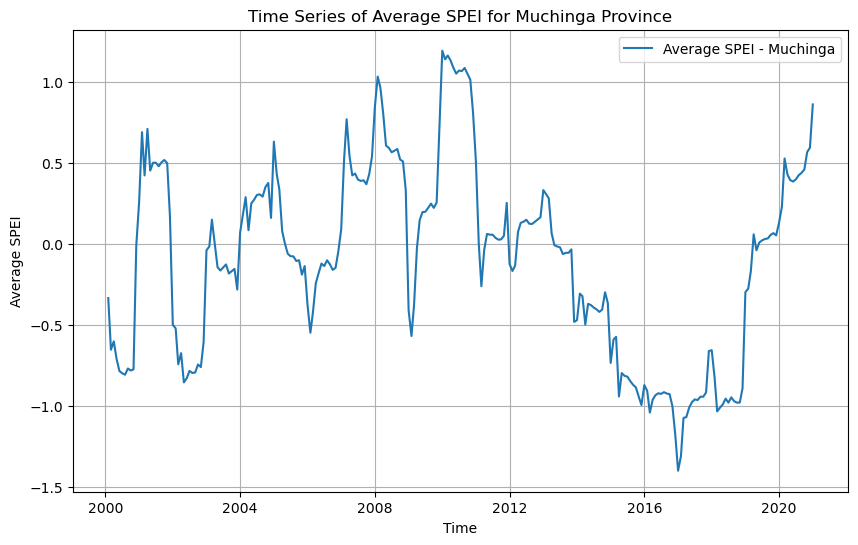

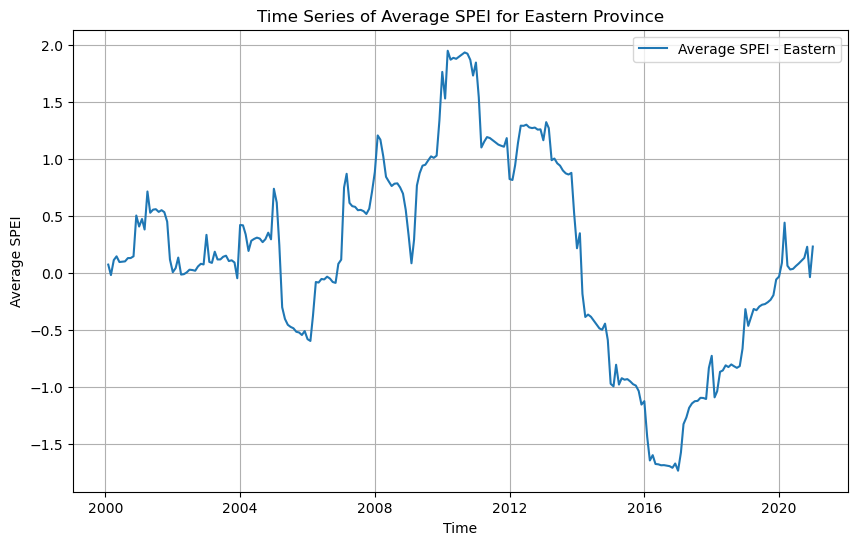

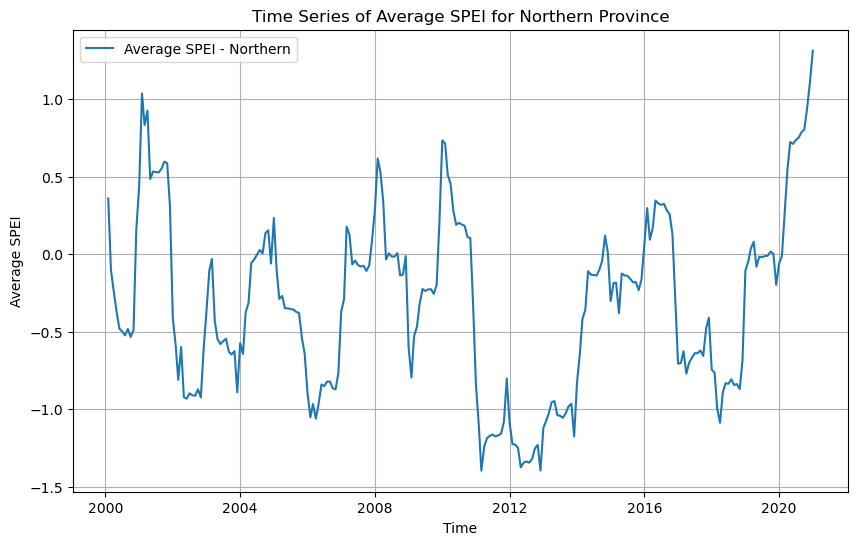

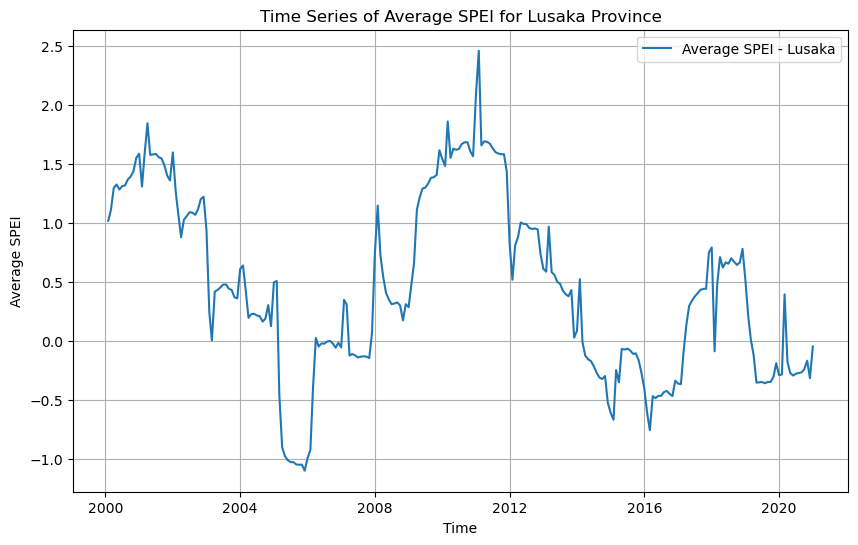

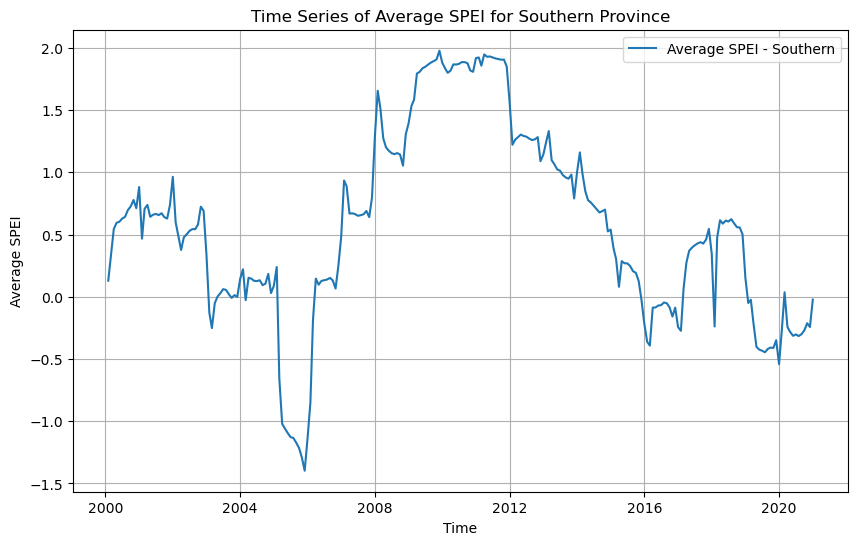

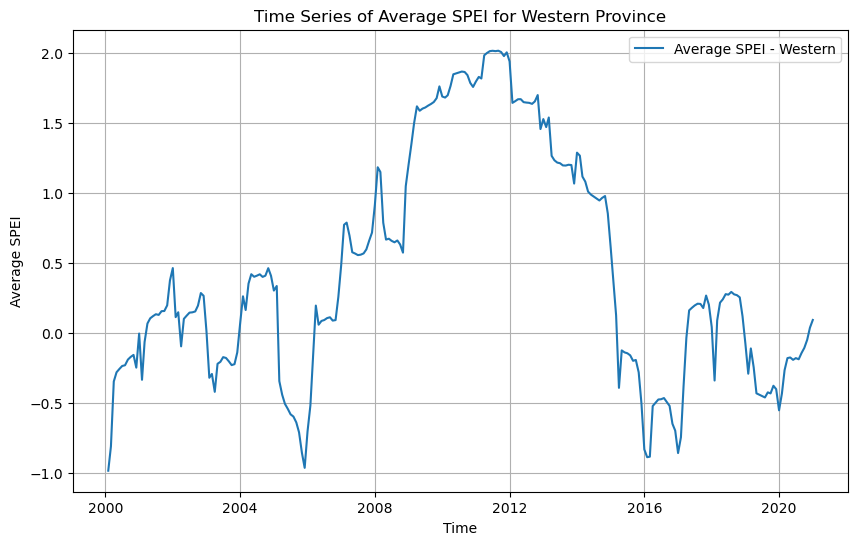

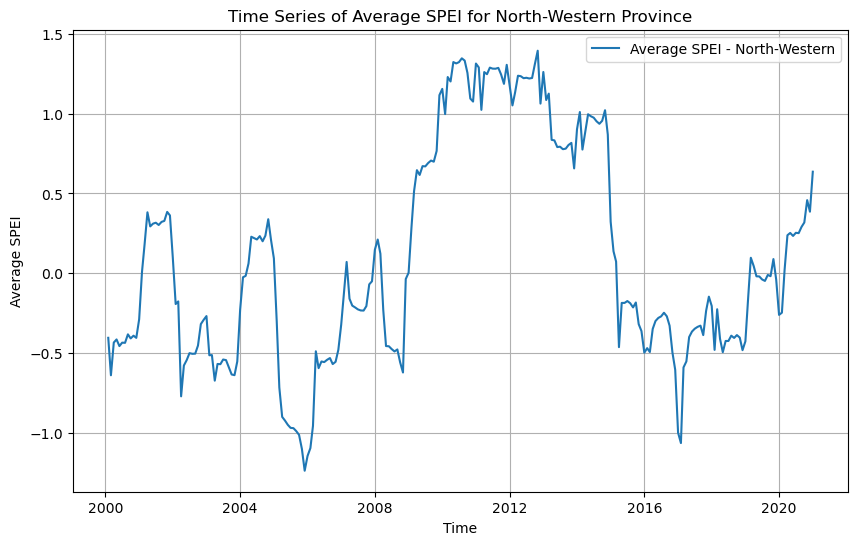

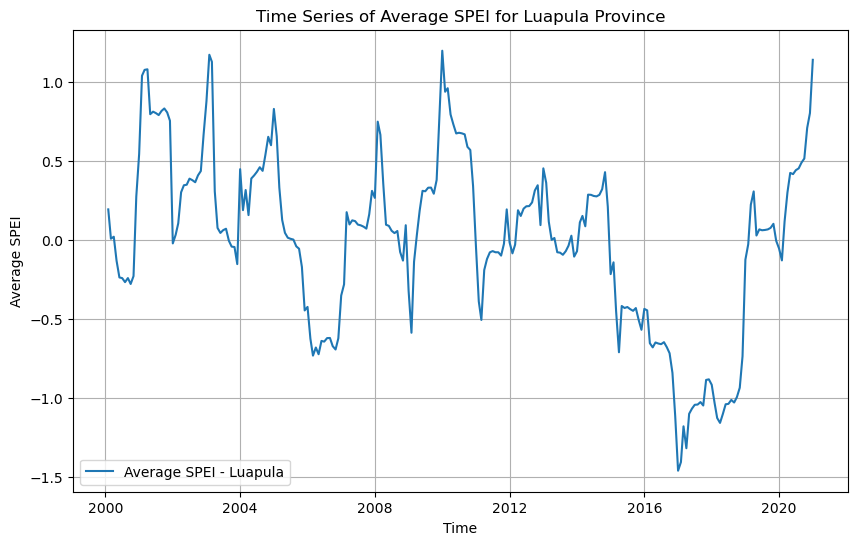

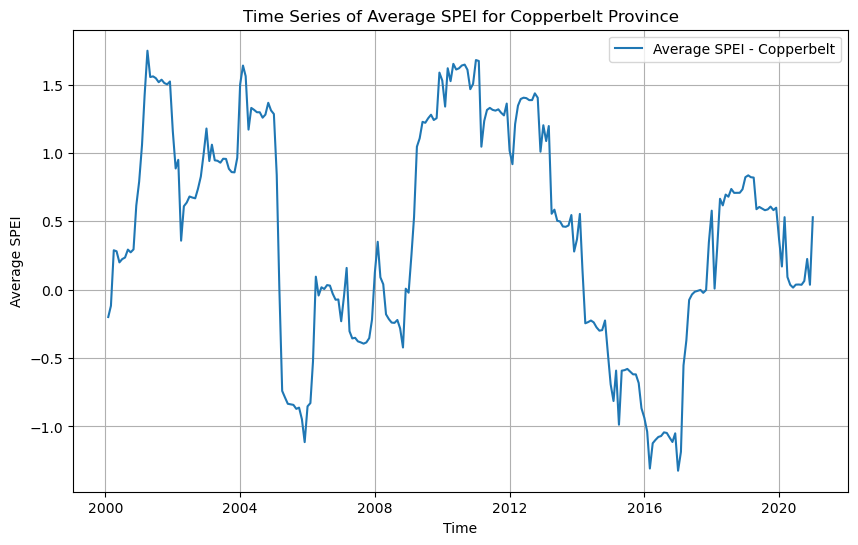

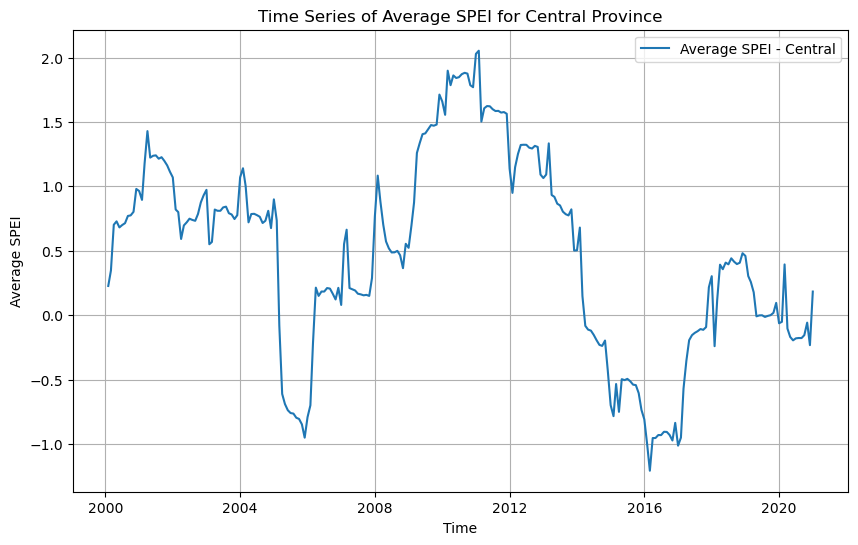

In [18]:
import dask.array as da

# loop to plot time series for each province
for province in provinces:
    province_geom = gdf[gdf['name'] == province].geometry.iloc[0]
    # set spatial dimensions for dask array
    spei_monthly_dask = spei_monthly.chunk({'lat': 100, 'lon': 100})
    spei_monthly_dask = spei_monthly_dask.rio.set_spatial_dims('lon', 'lat')
    # clip SPEI data
    spei_clipped_province = spei_monthly.rio.clip([mapping(province_geom)], crs = gdf.crs)
    # compute area average
    area_avg_province = spei_clipped_province.mean(dim = ['lat', 'lon'], skipna = True)

    # convert to datetime
    time_values = spei_clipped_province['time'].values
    time_dates = pd.to_datetime(time_values)

    # compute area average values
    area_avg_province_computed = area_avg_province['spei'].compute()
    # plot time series
    plt.figure(figsize = (10, 6))
    plt.plot(time_dates, area_avg_province_computed, label = f'Average SPEI - {province}')
    plt.xlabel('Time')
    plt.ylabel('Average SPEI')
    plt.title(f'Time Series of Average SPEI for {province} Province')
    plt.grid(True)
    plt.legend()
    plt.show()

## District Level

In [29]:
# load districts shapefile
district_level = 'Data/district.shp'
# read shapefile into geodataframe
gdf_districts = gpd.read_file(district_level)

In [30]:
# set CRS
gdf_districts.crs = 'EPSG:4326'

In [32]:
# extract district geometry for specific district
district_name = 'Mansa'
district_geom = gdf_districts[gdf_districts['NAME_2'] == district_name].geometry.iloc[0]

In [33]:
import dask.array as da

# set spatial dimensions for dask array
spei_monthly_dask = spei_monthly.chunk({'lat': 100, 'lon': 100})
spei_monthly_dask = spei_monthly_dask.rio.set_spatial_dims('lon', 'lat')

# clip SPEI data
spei_clipped_district = spei_monthly.rio.clip([mapping(province_geom)], crs = gdf.crs)

In [34]:
# compute area average
area_avg_district = spei_clipped_district.mean(dim = ['lat', 'lon'], skipna = True)

# convert to datetime
time_values = spei_clipped_district['time'].values
time_dates = pd.to_datetime(time_values)

# compute area average values
area_avg_district_computed = area_avg_district['spei'].compute()

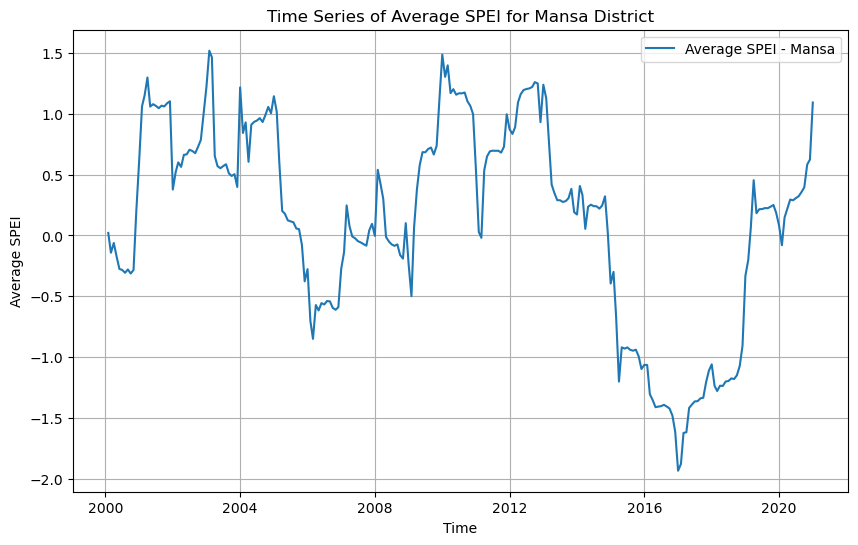

In [28]:
# plot time series for Mansa
plt.figure(figsize = (10, 6))
plt.plot(time_dates, area_avg_district_computed, label = f'Average SPEI - {district_name}')
plt.xlabel('Time')
plt.ylabel('Average SPEI')
plt.title(f'Time Series of Average SPEI for {district_name} District')
plt.grid(True)
plt.legend()
plt.show()

# Code graveyard

In [ ]:
# extract district geometry for specific province
province_name = 'Southern'
province_geom = gdf[gdf['name'] == province_name].geometry.iloc[0]

import dask.array as da

# set spatial dimensions for dask array
spei_monthly_dask = spei_monthly.chunk({'lat': 100, 'lon': 100})
spei_monthly_dask = spei_monthly_dask.rio.set_spatial_dims('lon', 'lat')

# clip SPEI data
spei_clipped_province = spei_monthly.rio.clip([mapping(province_geom)], crs = gdf.crs)

# compute area average
area_avg_province = spei_clipped_province.mean(dim = ['lat', 'lon'], skipna = True)

# convert to datetime
time_values = spei_clipped_province['time'].values
time_dates = pd.to_datetime(time_values)

# compute area average values
area_avg_province_computed = area_avg_province['spei'].compute()

# plot time series for Southern
plt.figure(figsize = (10, 6))
plt.plot(time_dates, area_avg_province_computed, label = f'Average SPEI - {province_name}')
plt.xlabel('Time')
plt.ylabel('Average SPEI')
plt.title(f'Time Series of Average SPEI for {province_name} Province')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for province in provinces:
    province_geom = gdf[gdf['name'] == province].geometry.iloc[0]
    spei_clipped = spei_monthly.rio.clip([mapping(province_geom)], crs=gdf.crs)
    spei_variable = spei_clipped['spei']
    
    # plot first time step
    spei_variable.sel(time='2000-01-31').plot(figsize=(10, 8))
    
    plt.title(f'Monthly Average SPEI for {province} on 2000-01-01')
    plt.show()

In [ ]:
# convert 'time' to datetime
time_values = spei_clipped['time'].values
time_dates = pd.to_datetime(time_values)

# compute area average
area_avg_computed = area_avg['spei'].compute()

# plot time series
plt.figure(figsize=(10,6))
plt.plot(time_dates, area_avg_computed, label = 'Average SPEI')
plt.xlabel('Time')
plt.ylabel('Average SPEI')
plt.title('Time Series of Average SPEI')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# create list to store results
district_time_series = {}

# loop to clip SPEI data for each district
for district in districts:
    # extract district geometry
    district_geom = gdf_districts[gdf_districts['NAME_2'] == district].geometry.iloc[0]
    # clip SPEI by district geometry
    spei_clipped = spei_monthly.rio.clip([mapping(district_geom)], crs=gdf.crs)
    # extract SPEI variable and calculate area average
    spei_variable = spei_clipped['spei']
    area_avg = spei_variable.mean(dim=['lat', 'lon'], skipna = True)

In [10]:
import glob

In [11]:
from glob import glob

In [12]:
file_list = sorted(glob.glob('*.nc'))

AttributeError: 'function' object has no attribute 'glob'

In [13]:
for file in file_list:
    nc_file = xarray.open_dataset(file)
    clipped_nc = nc_file.rio.clip(gdf.geometry.apply(mapping), gdf.crs, all_touched = True)

NameError: name 'file_list' is not defined

In [14]:
# create zambia shapefile mask
zambia_mask = rasterio.features.geometry_mask(gdf.iloc[0],
                                              out_shape = (len(spei.y), len(spei.x)),
                                              transform = spei.geobox.transform,
                                              invert = True)


NameError: name 'spei' is not defined

In [9]:
spei_raster = spei_data['spei']

In [10]:
spei_raster.rio.write_crs("EPSG:4326", inplace=True)  # Set the CRS for the raster data if not defined

# Step 5: Reproject the GeoDataFrame to the same CRS as the raster (if needed)
gdf = gdf.to_crs(spei_raster.rio.crs)

In [ ]:
# Set spatial dimensions explicitly for rioxarray
spei_raster = spei_raster.rename({'lat': 'y', 'lon': 'x'})

# Now we can clip the raster
clip_geometry = gdf.geometry.apply(mapping)
clipped_spei = spei_raster.rio.clip(clip_geometry, gdf.crs)

# Plot the clipped data
plt.figure(figsize=(10, 10))
clipped_spei.plot()
plt.title('Clipped SPEI Data for Zambia')
plt.show()

In [24]:
# clip SPEI raster to Zambia shapefile
clip_geometry = gdf.geometry.apply(mapping)
clipped_spei = spei_raster.rio.clip(clip_geometry, gdf.crs)

MissingSpatialDimensionError: y dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'y' can address this. Data variable: spei

In [18]:
clipped = raster.clip(gdf.geometry.apply(mapping), gdf.crs)

NameError: name 'raster' is not defined